# Exponential Smoothing

In [1]:
import warnings

warnings.simplefilter("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
)

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, ETSModel

from ipywidgets import interact

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv"
)
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


In [3]:
# Split into training/ testing datasets.
train = df[df.Time <= "2017-09-20 17:00:00"]
test = df[df.Time > "2017-09-20 17:00:00"]

Exponential smoothing is amonge one of the most widely used techniques in time series forecasting. 

The exponential smoothing methods use weighted averages of past observations (where weights decay exponentially for older values). In other words, the forecast is more influenced by recent values, compared with older observations.

* Would you trust a mean forecast?
* Would you trust a Naive forecast?
  
> Exponential Smoothing offers forecasts between these two extremes.

### Simple Exponential Smoothing (SES)

SES is a forecasting method that gives more weight to recent observations.

$\hat{y}_{T + 1 | T} = \alpha y_{T} + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + ...$, where $0\leq \alpha \leq1$ is the smoothing parameter. 

**N.B:**  $\hat{y}_{T + 1 | T}$ is our 1-step forecast based on data $y_{1} + y_{2} + ... + y_{T}$

* $\alpha$ is the smoothing factor (between 0 and 1).
* More recent values (like  $y_{T}$) get more weight.
* Older values get exponentially less weight.

This can be re-written recursively, making it easier to make a function in python:

Forecast equation: $\hat{y}_{t + h | T} = {l}_{t}$

Smoothing equation: ${l}_{t} = \alpha y_{t} + (1-\alpha){l}_{t-1}$

In [4]:
def SES_recurser(obs_series, alpha):
    """
    SES From Scratch.

    Inputs:
        obs_series (pandas.Series): Observational data.
        alpha (float): 0<=alpha<=1, the smoothing parameter.
    Output:
        list: Level of time series
    """
    level = [obs_series.iloc[0]]  # Initialise first value

    for t in range(1, len(obs_series)):

        updated_level = (
            obs_series.iloc[t] * alpha + (1 - alpha) * level[t - 1]
        )  # Level estimate
        level.append(updated_level)  # Store updated level

    return level

In [5]:
@interact(alpha=(0, 1, 0.01))
def plot_ses(alpha):

    level = SES_recurser(train["Ads"], alpha=alpha)

    fcst_fig = go.Figure()
    fcst_fig.add_trace(go.Scatter(x=train.Time, y=train["Ads"], name="Training data"))
    fcst_fig.add_trace(
        go.Scatter(x=train.Time, y=[np.nan] + level[:-1], name="One-step forecasts (in-sample)")
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time,
            y=[level[-1]] * len(test),
            name="SES forecast (out-of-sample)",
        )
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time, y=test.Ads, name="Test", line=dict(dash="dash", color="orange")
        )
    )

    fcst_fig.update_layout(
        title="Simple Exponential Smoothing",
        yaxis_title="avg_daily_attendances",
    )
    fcst_fig.show()

    # One step forecast in-sample error
    sse = (([np.nan] + level[:-1] - train["Ads"].values) ** 2)[1:].sum()
    print(f"Sum of Square Error (in-sample) = {sse}")

    # Test accuracy
    mape = mean_absolute_percentage_error(test.Ads, [level[-1]] * len(test))
    print(f"MAPE (out of-sample) = {round(mape* 100, 0)}%")

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

#### Task 1: SES using statsmodels

Verify forecasts match (when using the same alpha) when using both the custom recursive function and SES implimentation in statsmodels.

In [6]:
# ses_model = SimpleExpSmoothing(train["Ads"]).fit(
#     smoothing_level=0.1
# )

# ses_series = ses_model.predict(start=test.index[0], end=test.index[-1])
# ses_series.index = test.Time
# print(ses_series.head())

In [7]:
# level = SES_recurser(train["Ads"], alpha=0.1)
# forecasts = [level[-1]] * (len(test))
# custom_ses_series = pd.Series(forecasts)
# custom_ses_series.index = test.Time
# custom_ses_series.head()

Check for best alpha fit using statsmodels

In [8]:
# ses_model = SimpleExpSmoothing(train["Ads"]).fit(
#     optimized=True
# )
# print(ses_model.params_formatted)
# print(ses_model._sse)

* SES only forecasts a flat value (like the mean) -> only useful when your data has no trend or seasonality.
* A single parameter controls the weighting:
    - High alpha = more reactive to recent changed
    - Low alpha = more smooth, stable forecast 

### Double Exponential Smoothing (Holt's linear trend)

The previous forecast gave a flat forecast for the weighted average. If our time series if showing a clear trend, how can we include a trend in the forecast?

Holt's linear trend is an extension of SES, where we now have two smoothing equations. One for the level ($\alpha$) and one for the trend ($\beta$).

Forecast equation: $\hat{y}_{t + h | t} = l_{t} + hb_{t}$

Level equation: $l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1})$<br>
Trend equation: $b_{t} = \beta(l_{t} - l_{t-1}) + (1 - \beta)b_{t-1}$

In [9]:
def holts_linear_recursor(time_series, alpha, beta):
    """
    Double exponential smoothing from scratch.

    Inputs:
        time_series (pandas.Series): Observational data.
        alpha (float): 0 <= alpha <= 1, smoothing parameter for level.
        beta (float): 0 <= beta <= 1, smoothing parameter for trend.
    Output:
        level: Fitted level
        trend: Fitted trend
    """

    level = [time_series.iloc[0]]  # Initial level estimate (at t=0)
    trend = [
        time_series.iloc[1] - time_series.iloc[0]
    ]  # Initial trend estimate (at t=0)

    for t in range(1, len(time_series)):
        
        y = time_series.iloc[t]  # Observed data at t

        updated_level = alpha * y + (1 - alpha) * (
            level[-1] + trend[-1]
        )  # Updated level
        updated_trend = (
            beta * (updated_level - level[-1])
            + (1 - beta) * trend[-1]
        )  # Updated trend

        level.append(updated_level)
        trend.append(updated_trend)

    return level, trend

In [10]:
@interact(alpha=(0, 1, 0.01), beta=(0, 1, 0.01))
def plot_double_exp_smoothing(alpha, beta):

    level, trend = (holts_linear_recursor(train["Ads"], alpha, beta))

    fitted_vals = [np.nan] + [level[i-1] + 1 * trend[i-1] for i in range(1, len(train))]

    fcst_fig = go.Figure()

    fcst_fig.add_trace(go.Scatter(x=train.Time, y=train["Ads"], name="Training data"))
    fcst_fig.add_trace(
        go.Scatter(x=train.Time, y=fitted_vals, name="Fitted Holts Model")
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time,
            y=[
                level[-1] + h * trend[-1]
                for h in range(len(test))
            ],
            name="Holts forecast",
        )
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time, y=test.Ads, name="Test", line=dict(dash="dash", color="orange")
        )
    )

    fcst_fig.update_layout(
        height=350, width=900, title_text="Holt's Linear Trend Method"
    )
    fcst_fig.show()

    # One step forecast in-sample error
    sse = ((pd.Series(fitted_vals).values - train["Ads"].values) ** 2)[1:].sum()
    print(f"Sum of Square Error (in-sample) = {sse}")

    # Test accuracy
    mape = mean_absolute_percentage_error(
        test.Ads,
        [
            level[-1] + h * trend[-1]
            for h in range(len(test))
        ],
    )
    print(f"MAPE (out of-sample) = {round(mape* 100, 0)}%")

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), FloatSlider(value=0.0, …

#### Task 2: Holt method using statsmodels

Verify forecasts match (when using the same alpha & beta) when using both the custom recursive function and Holt implimentation in statsmodels.

Optional: Redo forecast in statsmodels but set `damped_trend=True` inside `Holt()`. Plot the results and compare.

In [11]:
holt_model = Holt(endog=train["Ads"],
                  # damped_trend=True
                 ).fit(
    smoothing_level=0.1, smoothing_trend=0.3
)

holt_series = holt_model.predict(start=test.index[0], end=test.index[-1])
print(holt_series.head())

168    145488.497955
169    146342.037668
170    147195.577381
171    148049.117094
172    148902.656807
dtype: float64


C:\Users\benjamin.holdsworth\.conda\envs\ben_test\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning



In [12]:
# level, trend = holts_linear_recursor(
#     train["Ads"], alpha=0.1, beta=0.3)

# forecasts = [level[-1] + h * trend[-1] for h in range(1, len(test))]
# custom_holt_series = pd.Series(forecasts)
# custom_holt_series.index = test.Time[1:]
# custom_holt_series.head()

In [13]:
# # Use damped trend
# holt_model_damped = Holt(endog=train["Ads"],
#                   damped_trend=True
#                  ).fit(
#     smoothing_level=0.1, smoothing_trend=0.3
# )

# holt_damped_series = holt_model_damped.predict(start=test.index[0], end=test.index[-1])
# print(holt_damped_series.head())

# pd.concat([holt_series, holt_damped_series], axis=1).plot(figsize = (15, 5))

Check for best alpha & beta

In [14]:
# holt_model = Holt(train["Ads"]).fit(
#     optimized=True
# )
# print(holt_model.params_formatted)
# print(holt_model._sse)

* Holt's linear method extends SES by handling trending data, but still assumes no seasonality.
* Two parameters control the forecast
    - Alpha = How quickly the level reacts to recent data
    - Beta = How quickly the slope reacts to recent data
* In practice, trends may flatten over time. There is a modification to Holt's method (damping methods) adding a new damping parameter that dampen the trend over time.

### Triple Exponential Smoothing (Holt-Winters seasonal method)

Finally, we consider a model that can incoorperate both seasonal and trend components. Holt-Winters extendes Holt's method, by adding a third smoothing equation for seasonality.

We therefore have three smoothing parameters, $\alpha$ (for level), $\beta$ (for trend), and $\gamma$ (for seasonality).

Forecast equation: $\hat{y}_{t + h | t} = l_{t} + hb_{t} + s_{t+h-m(k+1)}$, where k is the integer part from $\frac{h-1}{m}$.

Level equation: $l_{t} = \alpha (y_{t} - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1})$<br>
Trend equation: $b_{t} = \beta(l_{t} - l_{t-1}) + (1 - \beta)b_{t-1}$<br>
Seasonal equation: $s_{t} = \gamma(y_{t} - l_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m}$

We can also have a model for multiplicative seasonality, but we will just consider the additive model here.

In [15]:
def holt_winters_recursor(time_series, alpha, beta, gamma, season_length, h=1):
    # TODO
    pass

In [16]:
@interact(alpha=(0, 1, 0.01), beta=(0, 1, 0.01), gamma=(0, 1, 0.01))
def plot_triple_exp_smoothing(alpha, beta, gamma):

    hw_model = ExponentialSmoothing(
        endog=train["Ads"],
        seasonal_periods=24,
        trend="add",
        seasonal="add",
    ).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

    level_component = hw_model._level
    trend_component = hw_model._trend
    season_component = hw_model._season # Components for reference only

    fcst_fig = go.Figure()

    fcst_fig.add_trace(go.Scatter(x=train.Time, y=train["Ads"], name="Training data"))
    fcst_fig.add_trace(
        go.Scatter(x=train.Time, y=hw_model.fittedfcast, name="Fitted Holts Model")
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time,
            y=hw_model.predict(start=test.index[0], end=test.index[-1]),
            name="Holts Winters forecast",
        )
    )

    fcst_fig.add_trace(
        go.Scatter(
            x=test.Time, y=test.Ads, name="Test", line=dict(dash="dash", color="orange")
        )
    )

    fcst_fig.update_layout(
        height=350, width=900, title_text="Holt's Winters Linear Trend Method"
    )
    fcst_fig.show()

    # One step forecast in-sample error
    sse = hw_model.sse
    print(f"Sum of Square Error (in-sample) = {sse}")

    # Test accuracy
    mape = mean_absolute_percentage_error(
        test.Ads, hw_model.predict(start=test.index[0], end=test.index[-1])
    )
    print(f"MAPE (out of-sample) = {round(mape* 100, 0)}%")

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), FloatSlider(value=0.0, …

#### Task 3: Holt-Winters method using statsmodels

Check for best fit for parameters alpha, beta, and gamma.

In [17]:
# hw_model = ExponentialSmoothing(
#     endog=train["Ads"],
#     seasonal_periods=24,
#     trend="add",
#     seasonal="add",
# ).fit(optimized=True)
# print(hw_model.params_formatted)
# print(hw_model.sse)

## The ExponenTialSmoothing (ETS) framework

The ExponenTialSmoothing (ETS) is a unifying framework that brings together all the models described above together. It's a statistical framework that allows for probabilistic information (e.g., prediction intervals) rather than point forecasts as above. In practice, you will use some kind of ETS function to make forecasts.

In [18]:
ets_model = ETSModel(
    endog=train["Ads"],
    # All we need to do is specify the seasonal period,
    # And whether the trend/seasonal components are additive or multiplicative
    seasonal_periods=24,
    trend="add",
    seasonal="add",
).fit()

In [19]:
# Predict from trained model
pred = ets_model.get_prediction(
    start=test.index[1], end=test.index[-1]
)  # Prediction intervals
ets_prediction = pred.summary_frame(alpha=0.05)
ets_prediction.head()

,mean,pi_lower,pi_upper
169,92637.981610,63278.569439,121997.393782
170,106528.347140,70569.359203,142487.335077
171,129086.401271,87562.808632,170609.993911
172,153396.845801,106969.969013,199823.722590
173,154032.951294,103172.482853,204893.419736


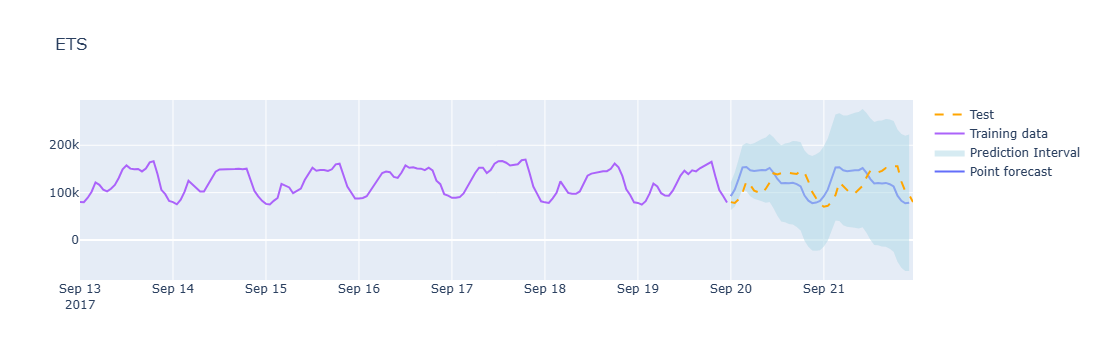

In [20]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=test.Time, y=ets_prediction["mean"], mode="lines", name="Point forecast"
    )
)

fig.add_trace(
    go.Scatter(
        x=test.Time,
        y=ets_prediction["pi_upper"],
        mode="lines",
        line=dict(width=0),
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=test.Time,
        y=ets_prediction["pi_lower"],
        mode="lines",
        line=dict(width=0),
        fill="tonexty",
        fillcolor="rgba(173,216,230,0.5)",
        name="Prediction Interval",
    )
)

fig.add_trace(go.Scatter(x=train.Time, y=train["Ads"], name="Training data"))
fig.update_layout(title="ETS")

fig.add_trace(
    go.Scatter(
        x=test.Time, y=test.Ads, name="Test", line=dict(dash="dash", color="orange")
    )
)

fig.show()

We can see the parameters the model has selected

In [21]:
ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    Ads   No. Observations:                  168
Model:                       ETS(AAA)   Log Likelihood               -1795.384
Date:                Tue, 21 Oct 2025   AIC                           3650.767
Time:                        11:25:16   BIC                           3744.486
Sample:                             0   HQIC                          3688.803
                                - 168   Scale                    112193717.531
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.032     31.086      0.000       0.937       1.063
smoothing_trend      9.999e-05        nan        nan        nan         nan         nan
smoothing_seasonal   9.999e-05        nan        nan        nan         nan         nan
initial_level        1.232e+05    1.2e+04     10.279      0.000    9.97e+04    1.47e+05
initial_trend          -6.5707        nan        nan        nan         nan         nan
initial_seasonal.0  -3402.2656   5421.012     -0.628      0.530    -1.4e+04    7222.723
initial_seasonal.1  -4701.4844   5104.303     -0.921      0.357   -1.47e+04    5302.765
initial_seasonal.2    646.4844   2752.262      0.235      0.814   -4747.849    6040.818
initial_seasonal.3   1.128e+04        nan        nan        nan         nan         nan
initial_seasonal.4   3.078e+04        nan        nan        nan         nan         nan
initial_seasonal.5   3.554e+04        nan        nan        nan         nan         nan
initial_seasonal.6    3.83e+04        nan        nan        nan         nan         nan
initial_seasonal.7    3.71e+04   2595.312     14.296      0.000     3.2e+04    4.22e+04
initial_seasonal.8   3.805e+04   2480.063     15.342      0.000    3.32e+04    4.29e+04
initial_seasonal.9   3.715e+04   3917.374      9.483      0.000    2.95e+04    4.48e+04
initial_seasonal.10  4.638e+04   4686.063      9.898      0.000    3.72e+04    5.56e+04
initial_seasonal.11  5.948e+04   5626.640     10.571      0.000    4.85e+04    7.05e+04
initial_seasonal.12  6.948e+04   5551.359     12.515      0.000    5.86e+04    8.04e+04
initial_seasonal.13  6.494e+04   3940.495     16.480      0.000    5.72e+04    7.27e+04
initial_seasonal.14    6.5e+04   1938.350     33.532      0.000    6.12e+04    6.88e+04
initial_seasonal.15   6.47e+04        nan        nan        nan         nan         nan
initial_seasonal.16  6.305e+04        nan        nan        nan         nan         nan
initial_seasonal.17  6.478e+04        nan        nan        nan         nan         nan
initial_seasonal.18  7.141e+04        nan        nan        nan         nan         nan
initial_seasonal.19  7.077e+04        nan        nan        nan         nan         nan
initial_seasonal.20  4.645e+04   1023.293     45.397      0.000    4.44e+04    4.85e+04
initial_seasonal.21  2.388e+04   3217.837      7.422      0.000    1.76e+04    3.02e+04
initial_seasonal.22  9985.2604   4960.719      2.013      0.044     262.430    1.97e+04
initial_seasonal.23          0   5431.700          0      1.000   -1.06e+04    1.06e+04
===================================================================================
Ljung-Box (Q):                      570.01   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               0.88   Skew:                            -0.16
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.48
=====

#### Optional Task: Use ETS to do SES with prediction intervals

In [22]:
# ets_model = ETSModel(
#     endog=train["Ads"],
#     trend=None,
#     seasonal=None, # No trend or seasonality for SES
# ).fit()

# # Predict from trained model

# ses_pred = ets_model.get_prediction(
#     start=test.index[1], end=test.index[-1]
# )  # Prediction intervals
# ses_pred_df = ses_pred.summary_frame(alpha=0.05)
# ses_pred_df.plot(figsize = (15, 5))